In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# RVs with multiple instruments

In this case study, we will look at how we can use exoplanet and PyMC3 to combine datasets from different RV instruments to fit the orbit of an exoplanet system.
Before getting started, I want to emphasize that the exoplanet code doesn't have strong opinions about how your data are collected, it only provides extensions that allow PyMC3 to evaluate some astronomy-specific functions.
This means that you can build any kind of observation model that PyMC3 supports, and support for multiple instruments isn't really a *feature* of exoplanet, even though it is easy to implement.

For the example, we'll use public observations of Pi Mensae which hosts two planets, but we'll ignore the inner planet because the significance of the RV signal is small enough that it won't affect our results.
The datasets that we'll use are from the Anglo-Australian Planet Search (AAT) and the HARPS archive.
As is commonly done, we will treat the HARPS observations as two independent datasets split in June 2015 when the HARPS hardware was upgraded.
Therefore, we'll consider three datasets that we will allow to have different instrumental parameters (RV offset and jitter), but shared orbital parameters and stellar variability.
In some cases you might also want to have a different astrophyscial variability model for each instrument (if, for example, the observations are made in very different bands), but we'll keep things simple for this example.

The AAT data are available from [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) and the HARPS observations can be downloaded from the [ESO Archive](http://archive.eso.org/wdb/wdb/adp/phase3_spectral/form).
For the sake of simplicity, we have extracted the HARPS RVs from the archive in advance using [Megan Bedell's harps_tools library](https://github.com/megbedell/harps_tools).

To start, download the data and plot them with a (very!) rough zero point correction.

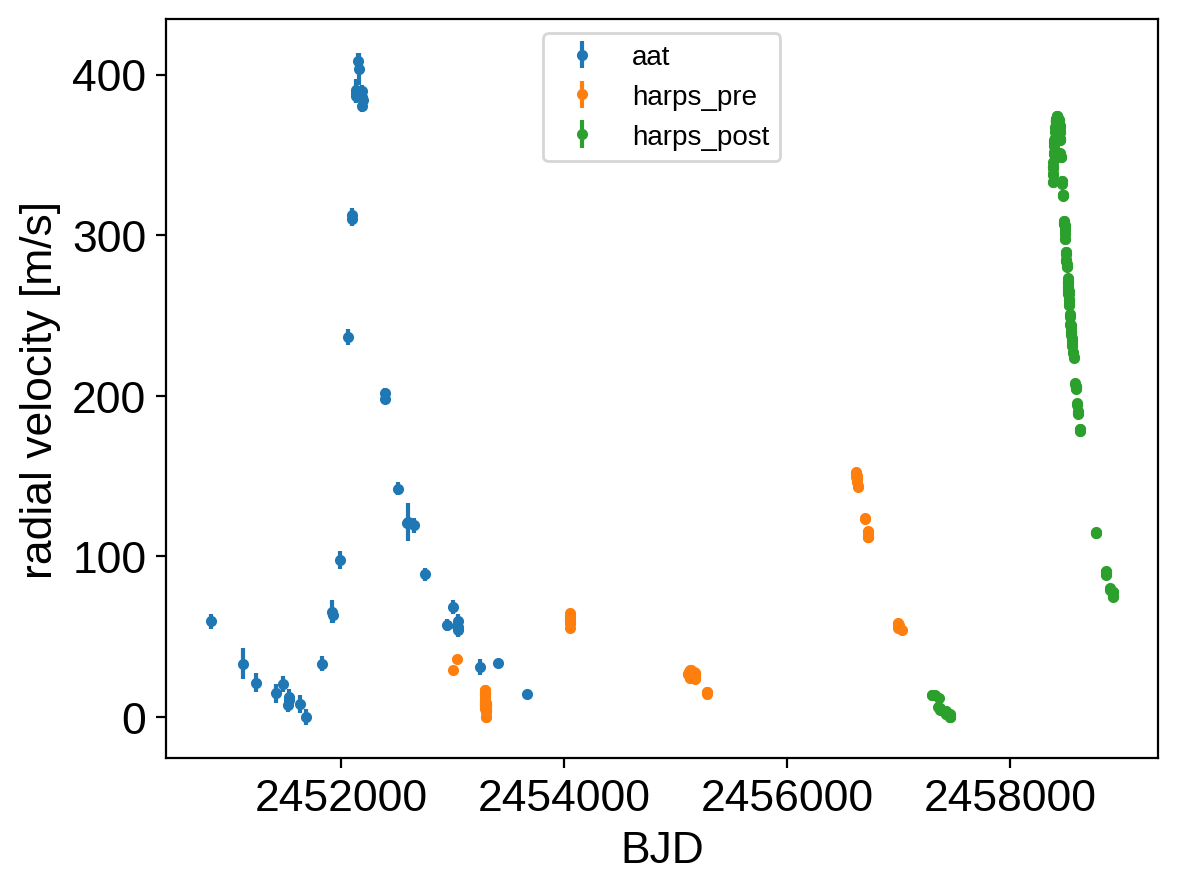

In [3]:
import numpy as np
import pandas as pd
from astropy.io import ascii

aat = ascii.read(
    "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0026/0026394/data/UID_0026394_RVC_001.tbl"
)
harps = pd.read_csv(
    "https://raw.githubusercontent.com/exoplanet-dev/case-studies/master/data/pi_men_harps_rvs.csv",
    skiprows=1,
)
harps = harps.rename(lambda x: x.strip().strip("#"), axis=1)
harps_post = np.array(harps.date > "2015-07-01", dtype=int)

t = np.concatenate((aat["JD"], harps["bjd"]))
rv = np.concatenate((aat["Radial_Velocity"], harps["rv"]))
rv_err = np.concatenate((aat["Radial_Velocity_Uncertainty"], harps["e_rv"]))
inst_id = np.concatenate((np.zeros(len(aat), dtype=int), harps_post + 1))

inds = np.argsort(t)
t = np.ascontiguousarray(t[inds], dtype=float)
rv = np.ascontiguousarray(rv[inds], dtype=float)
rv_err = np.ascontiguousarray(rv_err[inds], dtype=float)
inst_id = np.ascontiguousarray(inst_id[inds], dtype=int)

inst_names = ["aat", "harps_pre", "harps_post"]
num_inst = len(inst_names)

for i, name in enumerate(inst_names):
    m = inst_id == i
    plt.errorbar(t[m], rv[m] - np.min(rv[m]), yerr=rv_err[m], fmt=".", label=name)

plt.legend(fontsize=10)
plt.xlabel("BJD")
_ = plt.ylabel("radial velocity [m/s]")

Then set up the probabilistic model.
Most of this is similar to the model in the :ref:`rv` tutorial, but there are a few changes to highlight:

1. Instead of a polynomial model for trends, stellar varaiability, and inner planets, we're using a Gaussian process here. This won't have a big effect here, but more careful consideration should be performed when studying lower signal-to-noise systems.
2. There are three radial velocity offests and three jitter parameters (one for each instrument) that will be treated independently. This is the key addition made by this case study.

In [4]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

with pm.Model() as model:

    # Parameters describing the orbit
    K = pm.Lognormal("K", mu=np.log(300), sigma=10)
    P = pm.Lognormal("P", mu=np.log(2093.07), sigma=10)

    ecs = xo.UnitDisk("ecs", testval=np.array([0.7, -0.3]))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    phase = xo.UnitUniform("phase")
    tp = pm.Deterministic("tp", 0.5 * (t.min() + t.max()) + phase * P)

    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=tp, ecc=ecc, omega=omega)

    # Noise model parameters
    S_tot = pm.Lognormal("S_tot", mu=np.log(10), sigma=50)
    ell = pm.Lognormal("ell", mu=np.log(50), sigma=50)

    # Per instrument parameters
    means = pm.Normal(
        "means",
        mu=np.array([np.median(rv[inst_id == i]) for i in range(num_inst)]),
        sigma=200,
        shape=num_inst,
    )
    sigmas = pm.HalfNormal("sigmas", sigma=10, shape=num_inst)

    # Compute the RV offset and jitter for each data point depending on its instrument
    mean = tt.zeros(len(t))
    diag = tt.zeros(len(t))
    for i in range(len(inst_names)):
        mean += means[i] * (inst_id == i)
        diag += (rv_err ** 2 + sigmas[i] ** 2) * (inst_id == i)
    pm.Deterministic("mean", mean)
    pm.Deterministic("diag", diag)

    def rv_model(x):
        return orbit.get_radial_velocity(x, K=K)

    kernel = xo.gp.terms.SHOTerm(S_tot=S_tot, w0=2 * np.pi / ell, Q=1.0 / 3)
    gp = xo.gp.GP(kernel, t, diag, mean=rv_model)
    gp.marginal("obs", observed=rv - mean)
    pm.Deterministic("gp_pred", gp.predict())

    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [means])
    map_soln = xo.optimize(map_soln, [means, phase])
    map_soln = xo.optimize(map_soln, [means, phase, K])
    map_soln = xo.optimize(map_soln, [means, tp, K, P, ecs])
    map_soln = xo.optimize(map_soln, [sigmas, S_tot, ell])
    map_soln = xo.optimize(map_soln)

optimizing logp for variables: [means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.809431e+04]

1it [00:00, 232.54it/s, logp=-1.809431e+04]

2it [00:00, 329.91it/s, logp=-1.809431e+04]

3it [00:00, 338.32it/s, logp=-1.800406e+04]

4it [00:00, 372.20it/s, logp=-1.764945e+04]

5it [00:00, 400.42it/s, logp=-1.633369e+04]

6it [00:00, 400.81it/s, logp=-1.342429e+04]

7it [00:00, 406.21it/s, logp=-1.139325e+04]

8it [00:00, 418.75it/s, logp=-1.137849e+04]

9it [00:00, 422.17it/s, logp=-1.137149e+04]

10it [00:00, 423.80it/s, logp=-1.137138e+04]

11it [00:00, 429.47it/s, logp=-1.137136e+04]

12it [00:00, 431.28it/s, logp=-1.137136e+04]

13it [00:00, 434.80it/s, logp=-1.137136e+04]

14it [00:08,  1.61it/s, logp=-1.137136e+04] 


message: Optimization terminated successfully.
logp: -18094.31463741889 -> -11371.356631997516


optimizing logp for variables: [phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.137136e+04]

1it [00:00, 299.00it/s, logp=-1.137136e+04]

2it [00:00, 431.07it/s, logp=-1.137136e+04]

3it [00:00, 466.41it/s, logp=-3.346436e+04]

4it [00:00, 510.72it/s, logp=-1.129164e+04]

5it [00:00, 528.17it/s, logp=-1.124248e+04]

6it [00:00, 544.29it/s, logp=-1.123985e+04]

7it [00:00, 561.25it/s, logp=-1.123949e+04]

8it [00:00, 573.63it/s, logp=-1.123947e+04]

9it [00:00, 586.67it/s, logp=-1.123947e+04]

10it [00:00, 596.59it/s, logp=-1.123946e+04]

11it [00:00, 597.27it/s, logp=-1.123946e+04]

12it [00:00, 603.62it/s, logp=-1.123946e+04]

13it [00:00, 610.19it/s, logp=-1.123946e+04]

14it [00:00, 616.95it/s, logp=-1.123946e+04]

15it [00:00, 622.43it/s, logp=-1.123946e+04]

16it [00:00, 627.71it/s, logp=-1.123946e+04]

17it [00:00, 636.65it/s, logp=-1.123946e+04]

18it [00:00, 643.58it/s, logp=-1.123946e+04]

19it [00:00, 650.61it/s, logp=-1.123946e+04]

20it [00:00, 656.83it/s, logp=-1.123946e+04]

21it [00:00, 662.65it/s, logp=-1.123946e+04]

22it [00:00, 667.37it/s, logp=-1.123946e+04]

23it [00:00, 673.43it/s, logp=-1.123946e+04]

24it [00:00, 677.42it/s, logp=-1.123946e+04]

25it [00:00, 681.53it/s, logp=-1.123946e+04]

26it [00:00, 685.40it/s, logp=-1.123946e+04]

27it [00:00, 687.82it/s, logp=-1.123946e+04]

28it [00:00, 691.93it/s, logp=-1.123946e+04]

29it [00:00, 695.12it/s, logp=-1.123946e+04]

30it [00:00, 697.67it/s, logp=-1.123946e+04]

31it [00:00, 700.27it/s, logp=-1.123946e+04]

32it [00:00, 702.81it/s, logp=-1.123946e+04]

33it [00:00, 704.42it/s, logp=-1.123946e+04]

34it [00:00, 706.51it/s, logp=-1.123946e+04]

35it [00:00, 708.62it/s, logp=-1.123946e+04]

36it [00:00, 710.65it/s, logp=-1.123946e+04]

37it [00:00, 713.32it/s, logp=-1.123946e+04]

38it [00:00, 713.20it/s, logp=-1.123946e+04]

39it [00:00, 714.48it/s, logp=-1.123946e+04]

40it [00:00, 716.60it/s, logp=-1.123946e+04]

41it [00:00, 717.28it/s, logp=-1.123946e+04]

42it [00:00, 718.45it/s, logp=-1.123946e+04]

43it [00:00, 719.81it/s, logp=-1.123946e+04]

44it [00:00, 721.05it/s, logp=-1.123946e+04]

45it [00:00, 722.95it/s, logp=-1.123946e+04]

46it [00:00, 723.27it/s, logp=-1.123946e+04]

47it [00:00, 724.15it/s, logp=-1.123946e+04]

48it [00:00, 724.83it/s, logp=-1.123946e+04]

49it [00:00, 725.81it/s, logp=-1.123946e+04]

50it [00:00, 726.65it/s, logp=-1.123946e+04]

51it [00:00, 727.37it/s, logp=-1.123946e+04]

52it [00:00, 728.79it/s, logp=-1.123946e+04]

53it [00:00, 729.01it/s, logp=-1.123946e+04]

54it [00:00, 729.86it/s, logp=-1.123946e+04]

55it [00:00, 730.74it/s, logp=-1.123946e+04]

56it [00:00, 732.21it/s, logp=-1.123946e+04]

57it [00:00, 733.15it/s, logp=-1.123946e+04]

58it [00:00, 733.71it/s, logp=-1.123946e+04]

59it [00:00, 733.73it/s, logp=-1.123946e+04]

60it [00:00, 734.62it/s, logp=-1.123946e+04]

61it [00:00, 735.28it/s, logp=-1.123946e+04]

62it [00:00, 736.02it/s, logp=-1.123946e+04]

63it [00:00, 736.75it/s, logp=-1.123946e+04]

64it [00:00, 737.37it/s, logp=-1.123946e+04]

65it [00:00, 737.38it/s, logp=-1.123946e+04]

66it [00:00, 737.88it/s, logp=-1.123946e+04]

67it [00:00, 736.60it/s, logp=-1.123946e+04]

68it [00:00, 737.37it/s, logp=-1.123946e+04]

69it [00:00, 738.43it/s, logp=-1.123946e+04]

70it [00:00, 739.12it/s, logp=-1.123946e+04]

71it [00:00, 739.75it/s, logp=-1.123946e+04]

72it [00:00, 740.11it/s, logp=-1.123946e+04]

73it [00:00, 740.32it/s, logp=-1.123946e+04]

74it [00:00, 740.78it/s, logp=-1.123946e+04]

75it [00:00, 746.62it/s, logp=-1.123946e+04]

75it [00:00, 746.62it/s, logp=-1.123946e+04]

76it [00:00, 746.62it/s, logp=-1.123946e+04]

77it [00:00, 746.62it/s, logp=-1.123946e+04]

78it [00:00, 746.62it/s, logp=-1.123946e+04]

79it [00:00, 746.62it/s, logp=-1.123946e+04]

80it [00:00, 746.62it/s, logp=-1.123946e+04]

81it [00:00, 746.62it/s, logp=-1.123946e+04]

82it [00:00, 746.62it/s, logp=-1.123946e+04]

83it [00:00, 746.62it/s, logp=-1.123946e+04]

84it [00:00, 746.62it/s, logp=-1.123946e+04]

85it [00:00, 746.62it/s, logp=-1.123946e+04]

86it [00:00, 746.62it/s, logp=-1.123946e+04]

87it [00:00, 746.62it/s, logp=-1.123946e+04]

88it [00:00, 746.62it/s, logp=-1.123946e+04]

89it [00:00, 746.62it/s, logp=-1.123946e+04]

90it [00:00, 746.62it/s, logp=-1.123946e+04]

91it [00:00, 746.62it/s, logp=-1.123946e+04]

92it [00:00, 746.62it/s, logp=-1.123946e+04]

93it [00:00, 746.62it/s, logp=-1.123946e+04]

94it [00:00, 746.62it/s, logp=-1.123946e+04]

95it [00:00, 746.62it/s, logp=-1.123946e+04]

96it [00:00, 746.62it/s, logp=-1.123946e+04]

97it [00:00, 746.62it/s, logp=-1.123946e+04]

98it [00:00, 746.62it/s, logp=-1.123946e+04]

99it [00:00, 746.62it/s, logp=-1.123946e+04]

100it [00:00, 746.62it/s, logp=-1.123946e+04]

101it [00:00, 746.62it/s, logp=-1.123946e+04]

102it [00:00, 746.62it/s, logp=-1.123946e+04]

103it [00:00, 746.62it/s, logp=-1.123946e+04]

104it [00:00, 746.62it/s, logp=-1.123946e+04]

105it [00:00, 746.62it/s, logp=-1.123946e+04]

106it [00:00, 746.62it/s, logp=-1.123946e+04]

107it [00:00, 746.62it/s, logp=-1.123946e+04]

108it [00:00, 746.62it/s, logp=-1.123946e+04]

109it [00:00, 746.62it/s, logp=-1.123946e+04]

110it [00:00, 746.62it/s, logp=-1.123946e+04]

111it [00:00, 746.62it/s, logp=-1.123946e+04]

112it [00:00, 746.62it/s, logp=-1.123946e+04]

113it [00:00, 746.62it/s, logp=-1.123946e+04]

114it [00:00, 746.62it/s, logp=-1.123946e+04]

115it [00:00, 746.62it/s, logp=-1.123946e+04]

116it [00:00, 746.62it/s, logp=-1.123946e+04]

117it [00:00, 746.62it/s, logp=-1.123946e+04]

118it [00:00, 746.62it/s, logp=-1.123946e+04]

119it [00:00, 746.62it/s, logp=-1.123946e+04]

120it [00:00, 746.62it/s, logp=-1.123946e+04]

121it [00:00, 746.62it/s, logp=-1.123946e+04]

122it [00:00, 746.62it/s, logp=-1.123946e+04]

123it [00:00, 746.62it/s, logp=-1.123946e+04]

124it [00:00, 746.62it/s, logp=-1.123946e+04]

125it [00:00, 746.62it/s, logp=-1.123946e+04]

126it [00:00, 746.62it/s, logp=-1.123946e+04]

127it [00:00, 746.62it/s, logp=-1.123946e+04]

128it [00:00, 746.62it/s, logp=-1.123946e+04]

129it [00:00, 746.62it/s, logp=-1.123946e+04]

130it [00:00, 746.62it/s, logp=-1.123946e+04]

131it [00:00, 746.62it/s, logp=-1.123946e+04]

132it [00:00, 746.62it/s, logp=-1.123946e+04]

133it [00:00, 746.62it/s, logp=-1.123946e+04]

134it [00:00, 184.80it/s, logp=-1.123946e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -11371.356631997516 -> -11239.464875071475


optimizing logp for variables: [K, phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.123946e+04]

1it [00:00, 245.32it/s, logp=-1.123946e+04]

2it [00:00, 357.60it/s, logp=-1.123946e+04]

3it [00:00, 397.49it/s, logp=-1.074352e+04]

4it [00:00, 432.87it/s, logp=-9.979050e+03]

5it [00:00, 466.45it/s, logp=-1.679366e+04]

6it [00:00, 492.89it/s, logp=-8.506268e+03]

7it [00:00, 516.52it/s, logp=-8.419221e+03]

8it [00:00, 529.42it/s, logp=-1.623632e+04]

9it [00:00, 549.72it/s, logp=-8.371619e+03]

10it [00:00, 559.67it/s, logp=-8.275967e+03]

11it [00:00, 575.53it/s, logp=-7.903499e+03]

12it [00:00, 588.28it/s, logp=-6.581123e+03]

13it [00:00, 593.99it/s, logp=-3.827541e+03]

14it [00:00, 598.77it/s, logp=-2.110441e+03]

15it [00:00, 603.27it/s, logp=-1.786734e+03]

16it [00:00, 608.44it/s, logp=-1.600978e+03]

17it [00:00, 613.66it/s, logp=-1.543594e+03]

18it [00:00, 618.06it/s, logp=-1.516370e+03]

19it [00:00, 622.31it/s, logp=-1.509250e+03]

20it [00:00, 626.21it/s, logp=-1.509079e+03]

21it [00:00, 628.25it/s, logp=-1.509030e+03]

22it [00:00, 632.58it/s, logp=-1.509021e+03]

23it [00:00, 634.47it/s, logp=-1.509021e+03]

24it [00:00, 637.57it/s, logp=-1.509021e+03]

25it [00:00, 640.51it/s, logp=-1.509021e+03]

26it [00:00, 642.57it/s, logp=-1.509021e+03]

27it [00:00, 34.29it/s, logp=-1.509021e+03] 


message: Optimization terminated successfully.
logp: -11239.464875071475 -> -1509.0207936381803


optimizing logp for variables: [ecs, P, K, phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.509021e+03]

1it [00:00, 260.50it/s, logp=-1.509021e+03]

2it [00:00, 374.69it/s, logp=-1.509021e+03]

3it [00:00, 417.18it/s, logp=-1.554674e+04]

4it [00:00, 460.29it/s, logp=-5.895628e+03]

5it [00:00, 489.20it/s, logp=-1.453211e+03]

6it [00:00, 504.57it/s, logp=-1.468115e+03]

7it [00:00, 526.82it/s, logp=-1.428131e+03]

8it [00:00, 535.62it/s, logp=-1.396575e+03]

9it [00:00, 544.59it/s, logp=-1.362709e+03]

10it [00:00, 543.59it/s, logp=-1.371535e+03]

11it [00:00, 546.67it/s, logp=-1.347435e+03]

12it [00:00, 551.67it/s, logp=-1.333869e+03]

13it [00:00, 556.80it/s, logp=-1.330456e+03]

14it [00:00, 560.57it/s, logp=-1.329732e+03]

15it [00:00, 562.68it/s, logp=-1.329625e+03]

16it [00:00, 564.23it/s, logp=-1.329614e+03]

17it [00:00, 566.90it/s, logp=-1.329611e+03]

18it [00:00, 570.49it/s, logp=-1.329611e+03]

19it [00:00, 574.07it/s, logp=-1.329611e+03]

20it [00:00, 577.06it/s, logp=-1.329611e+03]

21it [00:00, 579.85it/s, logp=-1.329611e+03]

22it [00:00, 581.92it/s, logp=-1.329611e+03]

23it [00:00, 584.39it/s, logp=-1.329611e+03]

24it [00:00, 587.00it/s, logp=-1.329611e+03]

25it [00:00, 592.69it/s, logp=-1.329611e+03]

26it [00:00, 596.84it/s, logp=-1.329611e+03]

27it [00:00, 602.09it/s, logp=-1.329611e+03]

28it [00:00, 606.20it/s, logp=-1.329611e+03]

29it [00:00, 610.30it/s, logp=-1.329611e+03]

30it [00:00, 614.40it/s, logp=-1.329611e+03]

31it [00:00, 617.89it/s, logp=-1.329611e+03]

32it [00:00, 621.44it/s, logp=-1.329611e+03]

33it [00:00, 623.25it/s, logp=-1.329611e+03]

34it [00:00, 624.13it/s, logp=-1.329611e+03]

35it [00:00, 627.73it/s, logp=-1.329611e+03]

36it [00:00, 630.71it/s, logp=-1.329611e+03]

37it [00:00, 633.04it/s, logp=-1.329611e+03]

38it [00:00, 635.66it/s, logp=-1.329611e+03]

39it [00:00, 637.95it/s, logp=-1.329611e+03]

40it [00:00, 639.79it/s, logp=-1.329611e+03]

41it [00:00, 642.79it/s, logp=-1.329611e+03]

42it [00:00, 645.15it/s, logp=-1.329611e+03]

43it [00:00, 647.25it/s, logp=-1.329611e+03]

44it [00:00, 649.52it/s, logp=-1.329611e+03]

45it [00:00, 651.56it/s, logp=-1.329611e+03]

46it [00:00, 653.38it/s, logp=-1.329611e+03]

47it [00:00, 655.13it/s, logp=-1.329611e+03]

48it [00:00, 657.47it/s, logp=-1.329611e+03]

49it [00:00, 658.94it/s, logp=-1.329611e+03]

50it [00:00, 660.07it/s, logp=-1.329611e+03]

51it [00:00, 662.09it/s, logp=-1.329611e+03]

52it [00:00, 663.50it/s, logp=-1.329611e+03]

53it [00:00, 664.90it/s, logp=-1.329611e+03]

54it [00:00, 666.32it/s, logp=-1.329611e+03]

55it [00:00, 667.78it/s, logp=-1.329611e+03]

56it [00:00, 669.33it/s, logp=-1.329611e+03]

57it [00:00, 670.64it/s, logp=-1.329611e+03]

58it [00:00, 671.91it/s, logp=-1.329611e+03]

59it [00:00, 672.85it/s, logp=-1.329611e+03]

60it [00:00, 674.54it/s, logp=-1.329611e+03]

61it [00:00, 675.75it/s, logp=-1.329611e+03]

62it [00:00, 677.11it/s, logp=-1.329611e+03]

63it [00:00, 677.99it/s, logp=-1.329611e+03]

64it [00:00, 679.34it/s, logp=-1.329611e+03]

65it [00:00, 680.14it/s, logp=-1.329611e+03]

66it [00:00, 681.26it/s, logp=-1.329611e+03]

67it [00:00, 682.60it/s, logp=-1.329611e+03]

68it [00:00, 683.68it/s, logp=-1.329611e+03]

69it [00:00, 689.36it/s, logp=-1.329611e+03]

69it [00:00, 689.36it/s, logp=-1.329611e+03]

70it [00:00, 689.36it/s, logp=-1.329611e+03]

71it [00:00, 689.36it/s, logp=-1.329611e+03]

72it [00:00, 689.36it/s, logp=-1.329611e+03]

73it [00:00, 689.36it/s, logp=-1.329611e+03]

74it [00:00, 689.36it/s, logp=-1.329611e+03]

75it [00:00, 689.36it/s, logp=-1.329611e+03]

76it [00:00, 689.36it/s, logp=-1.329611e+03]

77it [00:00, 689.36it/s, logp=-1.329611e+03]

78it [00:00, 689.36it/s, logp=-1.329611e+03]

79it [00:00, 689.36it/s, logp=-1.329611e+03]

80it [00:00, 689.36it/s, logp=-1.329611e+03]

81it [00:00, 689.36it/s, logp=-1.329611e+03]

82it [00:00, 689.36it/s, logp=-1.329611e+03]

83it [00:00, 689.36it/s, logp=-1.329611e+03]

84it [00:00, 689.36it/s, logp=-1.329611e+03]

85it [00:00, 689.36it/s, logp=-1.329611e+03]

86it [00:00, 689.36it/s, logp=-1.329611e+03]

87it [00:00, 689.36it/s, logp=-1.329611e+03]

88it [00:00, 689.36it/s, logp=-1.329611e+03]

89it [00:00, 689.36it/s, logp=-1.329611e+03]

90it [00:00, 689.36it/s, logp=-1.329611e+03]

91it [00:00, 689.36it/s, logp=-1.329611e+03]

92it [00:00, 689.36it/s, logp=-1.329611e+03]

93it [00:00, 114.99it/s, logp=-1.329611e+03]


message: Optimization terminated successfully.
logp: -1509.0207936381803 -> -1329.6106228736105


optimizing logp for variables: [ell, S_tot, sigmas]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.329611e+03]

1it [00:00, 320.64it/s, logp=-1.329611e+03]

2it [00:00, 442.72it/s, logp=-1.329611e+03]

3it [00:00, 496.15it/s, logp=-1.120504e+03]

4it [00:00, 529.53it/s, logp=-1.507860e+03]

5it [00:00, 565.71it/s, logp=-1.080709e+03]

6it [00:00, 580.49it/s, logp=-1.022169e+03]

7it [00:00, 593.64it/s, logp=-9.503954e+02]

8it [00:00, 604.00it/s, logp=-9.515115e+02]

9it [00:00, 618.66it/s, logp=-9.057799e+02]

10it [00:00, 623.25it/s, logp=-8.556503e+02]

11it [00:00, 627.45it/s, logp=-8.626338e+02]

12it [00:00, 638.11it/s, logp=-8.518442e+02]

13it [00:00, 640.16it/s, logp=-8.465578e+02]

14it [00:00, 643.62it/s, logp=-8.455707e+02]

15it [00:00, 645.29it/s, logp=-8.455558e+02]

16it [00:00, 646.27it/s, logp=-8.455537e+02]

17it [00:00, 648.99it/s, logp=-8.455535e+02]

18it [00:00, 650.87it/s, logp=-8.455534e+02]

19it [00:00, 653.14it/s, logp=-8.455534e+02]

20it [00:00, 654.91it/s, logp=-8.455534e+02]

21it [00:00, 656.72it/s, logp=-8.455534e+02]

22it [00:00, 43.53it/s, logp=-8.455534e+02] 


message: Optimization terminated successfully.
logp: -1329.6106228736105 -> -845.553449086343


optimizing logp for variables: [sigmas, means, ell, S_tot, phase, ecs, P, K]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.455534e+02]

1it [00:00, 304.31it/s, logp=-8.455534e+02]

2it [00:00, 435.43it/s, logp=-8.455534e+02]

3it [00:00, 481.97it/s, logp=-9.756073e+04]

4it [00:00, 532.39it/s, logp=-8.861768e+02]

5it [00:00, 563.51it/s, logp=-8.450145e+02]

6it [00:00, 570.25it/s, logp=-8.443547e+02]

7it [00:00, 580.76it/s, logp=-8.435023e+02]

8it [00:00, 582.94it/s, logp=-8.448032e+02]

9it [00:00, 596.68it/s, logp=-8.432568e+02]

10it [00:00, 602.50it/s, logp=-8.499633e+02]

11it [00:00, 615.16it/s, logp=-8.432482e+02]

12it [00:00, 616.30it/s, logp=-8.432309e+02]

13it [00:00, 625.69it/s, logp=-8.431691e+02]

14it [00:00, 626.22it/s, logp=-8.430698e+02]

15it [00:00, 625.46it/s, logp=-8.432172e+02]

16it [00:00, 633.87it/s, logp=-8.430413e+02]

17it [00:00, 634.60it/s, logp=-8.429906e+02]

18it [00:00, 636.10it/s, logp=-8.430019e+02]

19it [00:00, 642.64it/s, logp=-8.429675e+02]

20it [00:00, 642.64it/s, logp=-8.429262e+02]

21it [00:00, 643.99it/s, logp=-8.428600e+02]

22it [00:00, 644.67it/s, logp=-8.428049e+02]

23it [00:00, 646.21it/s, logp=-8.428024e+02]

24it [00:00, 647.09it/s, logp=-8.428016e+02]

25it [00:00, 648.21it/s, logp=-8.428013e+02]

26it [00:00, 649.18it/s, logp=-8.428013e+02]

27it [00:00, 649.53it/s, logp=-8.428013e+02]

28it [00:00, 650.06it/s, logp=-8.428013e+02]

29it [00:00, 650.73it/s, logp=-8.428013e+02]

30it [00:00, 654.27it/s, logp=-8.428013e+02]

31it [00:00, 655.89it/s, logp=-8.428013e+02]

32it [00:00, 659.21it/s, logp=-8.428013e+02]

33it [00:00, 661.68it/s, logp=-8.428013e+02]

34it [00:00, 665.20it/s, logp=-8.428013e+02]

35it [00:00, 668.18it/s, logp=-8.428013e+02]

36it [00:00, 671.36it/s, logp=-8.428013e+02]

37it [00:00, 674.78it/s, logp=-8.428013e+02]

38it [00:00, 677.95it/s, logp=-8.428013e+02]

39it [00:00, 681.13it/s, logp=-8.428013e+02]

40it [00:00, 684.18it/s, logp=-8.428013e+02]

41it [00:00, 687.18it/s, logp=-8.428013e+02]

42it [00:00, 689.92it/s, logp=-8.428013e+02]

43it [00:00, 692.49it/s, logp=-8.428013e+02]

44it [00:00, 695.16it/s, logp=-8.428013e+02]

45it [00:00, 697.62it/s, logp=-8.428013e+02]

46it [00:00, 700.05it/s, logp=-8.428013e+02]

47it [00:00, 701.97it/s, logp=-8.428013e+02]

48it [00:00, 704.00it/s, logp=-8.428013e+02]

49it [00:00, 706.19it/s, logp=-8.428013e+02]

50it [00:00, 708.29it/s, logp=-8.428013e+02]

51it [00:00, 710.43it/s, logp=-8.428013e+02]

52it [00:00, 712.30it/s, logp=-8.428013e+02]

53it [00:00, 714.10it/s, logp=-8.428013e+02]

54it [00:00, 716.03it/s, logp=-8.428013e+02]

55it [00:00, 718.06it/s, logp=-8.428013e+02]

56it [00:00, 720.01it/s, logp=-8.428013e+02]

57it [00:00, 721.82it/s, logp=-8.428013e+02]

58it [00:00, 723.02it/s, logp=-8.428013e+02]

59it [00:00, 724.62it/s, logp=-8.428013e+02]

60it [00:00, 725.16it/s, logp=-8.428013e+02]

61it [00:00, 726.53it/s, logp=-8.428013e+02]

62it [00:00, 728.02it/s, logp=-8.428013e+02]

63it [00:00, 729.59it/s, logp=-8.428013e+02]

64it [00:00, 730.65it/s, logp=-8.428013e+02]

65it [00:00, 732.22it/s, logp=-8.428013e+02]

66it [00:00, 733.23it/s, logp=-8.428013e+02]

67it [00:00, 733.92it/s, logp=-8.428013e+02]

68it [00:00, 735.19it/s, logp=-8.428013e+02]

69it [00:00, 736.53it/s, logp=-8.428013e+02]

70it [00:00, 737.31it/s, logp=-8.428013e+02]

71it [00:00, 738.30it/s, logp=-8.428013e+02]

72it [00:00, 739.42it/s, logp=-8.428013e+02]

73it [00:00, 740.64it/s, logp=-8.428013e+02]

74it [00:00, 741.82it/s, logp=-8.428013e+02]

75it [00:00, 747.99it/s, logp=-8.428013e+02]

75it [00:00, 747.99it/s, logp=-8.428013e+02]

76it [00:00, 747.99it/s, logp=-8.428013e+02]

77it [00:00, 747.99it/s, logp=-8.428013e+02]

78it [00:00, 747.99it/s, logp=-8.428013e+02]

79it [00:00, 747.99it/s, logp=-8.428013e+02]

80it [00:00, 747.99it/s, logp=-8.428013e+02]

81it [00:00, 747.99it/s, logp=-8.428013e+02]

82it [00:00, 747.99it/s, logp=-8.428013e+02]

83it [00:00, 747.99it/s, logp=-8.428013e+02]

84it [00:00, 747.99it/s, logp=-8.428013e+02]

85it [00:00, 747.99it/s, logp=-8.428013e+02]

86it [00:00, 747.99it/s, logp=-8.428013e+02]

87it [00:00, 747.99it/s, logp=-8.428013e+02]

88it [00:00, 747.99it/s, logp=-8.428013e+02]

89it [00:00, 747.99it/s, logp=-8.428013e+02]

90it [00:00, 747.99it/s, logp=-8.428013e+02]

91it [00:00, 747.99it/s, logp=-8.428013e+02]

92it [00:00, 747.99it/s, logp=-8.428013e+02]

93it [00:00, 747.99it/s, logp=-8.428013e+02]

94it [00:00, 747.99it/s, logp=-8.428013e+02]

95it [00:00, 747.99it/s, logp=-8.428013e+02]

96it [00:00, 747.99it/s, logp=-8.428013e+02]

97it [00:00, 747.99it/s, logp=-8.428013e+02]

98it [00:00, 747.99it/s, logp=-8.428013e+02]

99it [00:00, 747.99it/s, logp=-8.428013e+02]

100it [00:00, 747.99it/s, logp=-8.428013e+02]

101it [00:00, 118.86it/s, logp=-8.428013e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: -845.553449086343 -> -842.8013426538246


After fitting for the parameters that maximize the posterior probability, we can plot this model to make sure that things are looking reasonable:

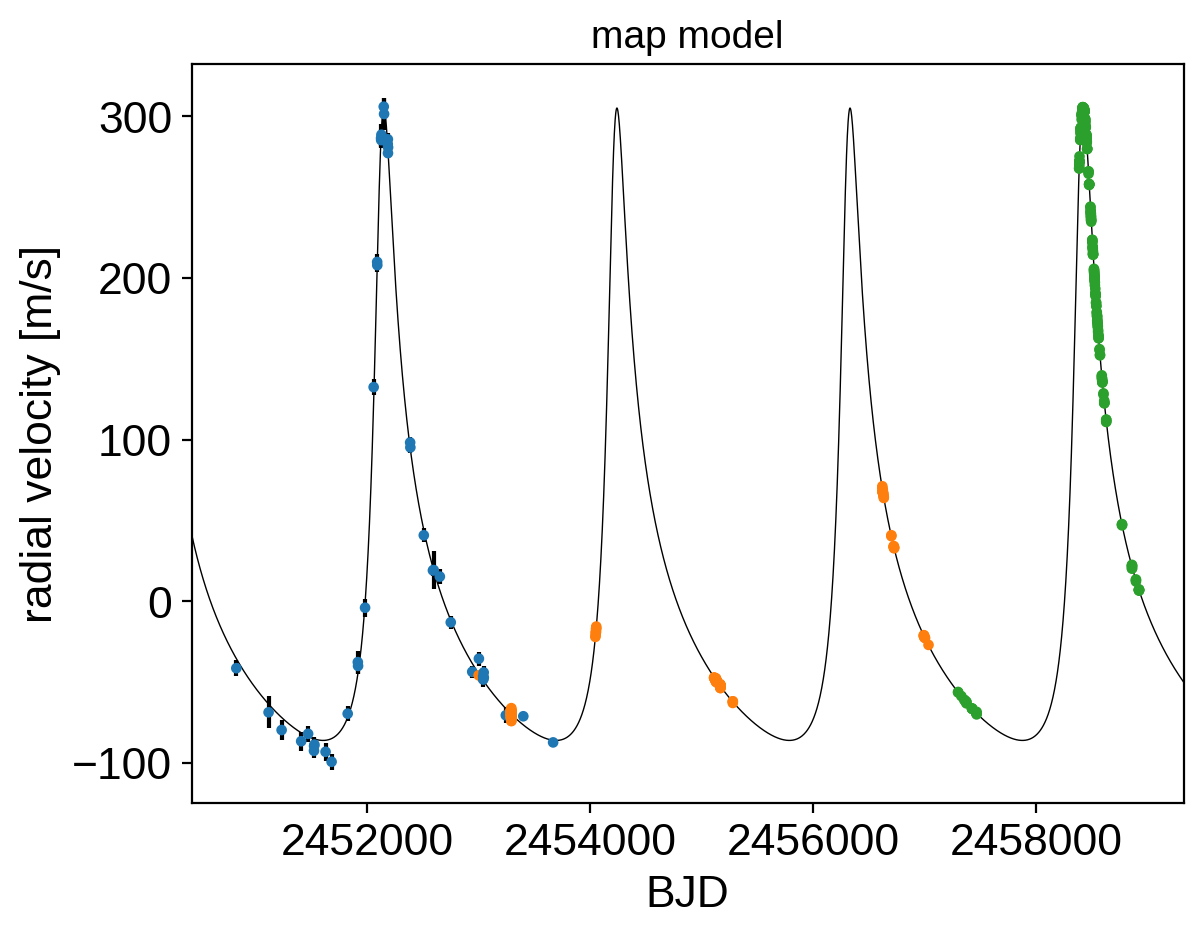

In [5]:
t_pred = np.linspace(t.min() - 400, t.max() + 400, 5000)
with model:
    plt.plot(t_pred, xo.eval_in_model(rv_model(t_pred), map_soln), "k", lw=0.5)

detrended = rv - map_soln["mean"] - map_soln["gp_pred"]
plt.errorbar(t, detrended, yerr=rv_err, fmt=",k")
plt.scatter(t, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10)
plt.xlim(t_pred.min(), t_pred.max())
plt.xlabel("BJD")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("map model", fontsize=14)

That looks fine, so now we can run the MCMC sampler:

In [6]:
np.random.seed(39091)
with model:
    trace = pm.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=2,
        step=xo.get_dense_nuts_step(start=map_soln, target_accept=0.95),
    )

Multiprocess sampling (2 chains in 4 jobs)


NUTS: [sigmas, means, ell, S_tot, phase, ecs, P, K]


Sampling 2 chains, 0 divergences:   0%|          | 0/13000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/13000 [00:00<04:20, 49.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/13000 [00:00<08:00, 27.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/13000 [00:00<10:34, 20.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/13000 [00:00<12:21, 17.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/13000 [00:00<13:35, 15.92draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/13000 [00:00<14:29, 14.94draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/13000 [00:01<15:04, 14.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/13000 [00:01<15:29, 13.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/13000 [00:01<16:11, 13.36draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/13000 [00:01<16:29, 13.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/13000 [00:01<16:38, 12.99draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/13000 [00:01<16:44, 12.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 33/13000 [00:02<16:48, 12.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/13000 [00:02<16:51, 12.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 37/13000 [00:02<16:53, 12.79draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 39/13000 [00:02<16:53, 12.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/13000 [00:02<16:54, 12.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 43/13000 [00:02<16:54, 12.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 45/13000 [00:02<16:54, 12.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 47/13000 [00:03<16:45, 12.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/13000 [00:03<16:36, 12.99draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/13000 [00:03<16:31, 13.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/13000 [00:03<16:27, 13.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/13000 [00:03<16:24, 13.15draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/13000 [00:03<16:22, 13.17draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/13000 [00:04<16:29, 13.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/13000 [00:04<16:37, 12.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 63/13000 [00:04<16:43, 12.89draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 65/13000 [00:04<16:47, 12.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 67/13000 [00:04<16:50, 12.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 69/13000 [00:04<16:50, 12.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 71/13000 [00:04<16:38, 12.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 73/13000 [00:05<16:39, 12.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 75/13000 [00:05<16:32, 13.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 78/13000 [00:05<15:00, 14.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/13000 [00:05<15:21, 14.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 83/13000 [00:05<13:58, 15.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 85/13000 [00:05<14:38, 14.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 87/13000 [00:06<15:06, 14.25draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 89/13000 [00:06<15:24, 13.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 91/13000 [00:06<15:43, 13.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/13000 [00:06<15:51, 13.56draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 95/13000 [00:06<15:56, 13.49draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/13000 [00:06<15:59, 13.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/13000 [00:06<16:01, 13.42draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 101/13000 [00:07<16:02, 13.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 103/13000 [00:07<16:04, 13.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 105/13000 [00:07<16:06, 13.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 107/13000 [00:07<16:18, 13.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 109/13000 [00:07<16:16, 13.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/13000 [00:07<16:15, 13.22draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 113/13000 [00:08<16:13, 13.24draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/13000 [00:08<16:11, 13.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 117/13000 [00:08<15:15, 14.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/13000 [00:08<15:43, 13.66draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/13000 [00:08<16:02, 13.38draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/13000 [00:08<16:17, 13.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/13000 [00:08<16:26, 13.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 127/13000 [00:09<16:25, 13.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 129/13000 [00:09<16:43, 12.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/13000 [00:09<16:33, 12.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 133/13000 [00:09<16:25, 13.06draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 135/13000 [00:09<16:20, 13.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/13000 [00:09<16:15, 13.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 139/13000 [00:09<16:12, 13.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 141/13000 [00:10<16:09, 13.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/13000 [00:10<16:07, 13.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 145/13000 [00:10<16:06, 13.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/13000 [00:10<16:06, 13.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/13000 [00:10<16:05, 13.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/13000 [00:10<16:04, 13.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 153/13000 [00:11<16:04, 13.33draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 155/13000 [00:11<16:13, 13.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/13000 [00:11<16:11, 13.22draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/13000 [00:11<16:08, 13.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 161/13000 [00:11<16:07, 13.27draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 163/13000 [00:11<16:06, 13.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 165/13000 [00:11<16:05, 13.29draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 167/13000 [00:12<16:04, 13.30draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 169/13000 [00:12<16:03, 13.32draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 171/13000 [00:12<16:03, 13.31draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 173/13000 [00:12<16:03, 13.32draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 175/13000 [00:12<16:02, 13.32draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 177/13000 [00:12<16:04, 13.29draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 179/13000 [00:12<16:15, 13.14draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 181/13000 [00:13<16:24, 13.02draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 183/13000 [00:13<16:29, 12.95draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 185/13000 [00:13<16:33, 12.90draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 187/13000 [00:13<16:47, 12.72draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 189/13000 [00:13<16:46, 12.73draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 191/13000 [00:13<16:46, 12.72draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 193/13000 [00:14<16:45, 12.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 195/13000 [00:14<16:44, 12.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 197/13000 [00:14<16:44, 12.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 199/13000 [00:14<16:44, 12.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 201/13000 [00:14<16:44, 12.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 203/13000 [00:14<16:43, 12.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 205/13000 [00:15<16:42, 12.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 207/13000 [00:15<16:41, 12.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 209/13000 [00:15<16:41, 12.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 211/13000 [00:15<16:41, 12.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 213/13000 [00:15<16:40, 12.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 215/13000 [00:15<16:40, 12.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 217/13000 [00:15<16:39, 12.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 219/13000 [00:16<16:39, 12.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 221/13000 [00:16<16:39, 12.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 223/13000 [00:16<16:28, 12.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 225/13000 [00:16<16:18, 13.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 227/13000 [00:16<16:11, 13.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 229/13000 [00:16<16:06, 13.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 231/13000 [00:17<16:02, 13.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 233/13000 [00:17<16:09, 13.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 235/13000 [00:17<16:07, 13.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 237/13000 [00:17<16:04, 13.23draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 239/13000 [00:17<16:02, 13.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 241/13000 [00:17<16:00, 13.28draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/13000 [00:17<15:59, 13.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 245/13000 [00:18<15:58, 13.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 247/13000 [00:18<15:57, 13.32draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/13000 [00:18<15:56, 13.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 251/13000 [00:18<15:56, 13.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/13000 [00:18<15:55, 13.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 255/13000 [00:18<15:54, 13.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/13000 [00:18<15:54, 13.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 259/13000 [00:19<15:55, 13.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/13000 [00:19<15:54, 13.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 263/13000 [00:19<15:55, 13.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/13000 [00:19<15:54, 13.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 267/13000 [00:19<15:54, 13.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/13000 [00:19<15:54, 13.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/13000 [00:20<16:05, 13.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/13000 [00:20<16:13, 13.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 275/13000 [00:20<16:20, 12.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/13000 [00:20<16:25, 12.92draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/13000 [00:20<16:28, 12.87draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/13000 [00:20<16:29, 12.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 283/13000 [00:20<16:31, 12.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/13000 [00:21<16:31, 12.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/13000 [00:21<16:32, 12.81draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 289/13000 [00:21<16:33, 12.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/13000 [00:21<16:33, 12.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/13000 [00:21<16:33, 12.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 295/13000 [00:21<16:32, 12.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/13000 [00:22<16:32, 12.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 299/13000 [00:22<16:32, 12.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 301/13000 [00:22<16:32, 12.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 303/13000 [00:22<15:24, 13.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/13000 [00:22<14:23, 14.70draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 307/13000 [00:22<15:01, 14.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/13000 [00:22<15:00, 14.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 312/13000 [00:23<14:07, 14.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/13000 [00:23<15:01, 14.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 318/13000 [00:23<12:09, 17.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 321/13000 [00:23<11:41, 18.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 324/13000 [00:23<11:21, 18.61draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 327/13000 [00:23<11:07, 18.99draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 330/13000 [00:23<10:55, 19.32draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 335/13000 [00:24<09:06, 23.19draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 344/13000 [00:24<07:10, 29.38draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 354/13000 [00:24<05:45, 36.64draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 366/13000 [00:24<04:35, 45.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 381/13000 [00:24<03:39, 57.50draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 394/13000 [00:24<03:03, 68.77draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 405/13000 [00:24<02:44, 76.39draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 419/13000 [00:24<02:22, 88.00draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 437/13000 [00:24<02:01, 103.31draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 454/13000 [00:25<01:48, 115.87draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 472/13000 [00:25<01:36, 129.62draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 495/13000 [00:25<01:23, 149.00draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 518/13000 [00:25<01:15, 166.31draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 542/13000 [00:25<01:08, 182.59draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 566/13000 [00:25<01:03, 195.41draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 588/13000 [00:25<01:05, 188.63draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 609/13000 [00:25<01:04, 193.31draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 631/13000 [00:25<01:02, 199.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 653/13000 [00:25<01:00, 203.93draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 674/13000 [00:26<01:00, 204.72draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 697/13000 [00:26<00:58, 210.30draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 720/13000 [00:26<00:57, 214.09draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 747/13000 [00:26<00:54, 226.00draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 773/13000 [00:26<00:52, 233.40draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 798/13000 [00:26<00:52, 233.12draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 823/13000 [00:26<00:51, 236.08draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 850/13000 [00:26<00:50, 242.57draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 876/13000 [00:26<00:49, 245.13draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 901/13000 [00:27<00:51, 236.90draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 925/13000 [00:27<00:51, 235.49draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 951/13000 [00:27<00:50, 240.12draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 980/13000 [00:27<00:48, 249.81draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1006/13000 [00:27<00:47, 250.16draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1034/13000 [00:27<00:46, 255.60draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1064/13000 [00:27<00:44, 267.34draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1092/13000 [00:27<00:44, 268.67draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1120/13000 [00:27<00:46, 257.84draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1146/13000 [00:27<00:47, 251.70draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1172/13000 [00:28<00:47, 248.11draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1197/13000 [00:28<00:47, 245.94draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1222/13000 [00:28<00:47, 247.12draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1247/13000 [00:28<00:48, 242.06draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1272/13000 [00:28<00:50, 233.68draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1296/13000 [00:28<00:50, 232.73draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1320/13000 [00:28<00:50, 230.46draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1344/13000 [00:28<00:51, 228.17draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1368/13000 [00:28<00:50, 229.64draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1391/13000 [00:29<00:50, 228.01draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1414/13000 [00:29<00:51, 223.84draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1438/13000 [00:29<00:51, 225.30draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1468/13000 [00:29<00:47, 242.69draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1493/13000 [00:29<00:50, 229.54draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1517/13000 [00:29<00:52, 220.04draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1540/13000 [00:29<00:53, 216.16draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1562/13000 [00:29<00:52, 216.38draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1587/13000 [00:29<00:51, 222.95draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1617/13000 [00:30<00:47, 240.89draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1642/13000 [00:30<00:46, 242.07draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1667/13000 [00:30<00:47, 238.04draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1692/13000 [00:30<00:47, 237.18draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1718/13000 [00:30<00:46, 241.58draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1743/13000 [00:30<00:46, 241.90draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1771/13000 [00:30<00:44, 251.97draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1797/13000 [00:30<00:47, 238.04draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1822/13000 [00:30<00:46, 241.29draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1850/13000 [00:30<00:44, 248.82draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1878/13000 [00:31<00:43, 255.70draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1905/13000 [00:31<00:43, 256.42draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1932/13000 [00:31<00:42, 260.23draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1959/13000 [00:31<00:42, 257.54draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1986/13000 [00:31<00:42, 260.28draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2013/13000 [00:31<00:42, 260.58draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2040/13000 [00:31<00:43, 250.66draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2066/13000 [00:31<00:44, 245.12draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2093/13000 [00:31<00:43, 248.70draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2121/13000 [00:32<00:42, 254.41draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2147/13000 [00:32<00:42, 252.59draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2173/13000 [00:32<00:44, 241.73draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2198/13000 [00:32<00:45, 237.39draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2222/13000 [00:32<00:46, 232.96draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2246/13000 [00:32<00:46, 231.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2270/13000 [00:32<00:47, 225.43draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2293/13000 [00:32<00:47, 225.18draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2322/13000 [00:32<00:44, 239.33draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2349/13000 [00:32<00:43, 244.58draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2374/13000 [00:33<00:45, 234.66draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2398/13000 [00:33<00:45, 234.18draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2424/13000 [00:33<00:44, 239.71draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2450/13000 [00:33<00:43, 245.22draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2476/13000 [00:33<00:42, 246.92draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2501/13000 [00:33<00:43, 242.33draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2526/13000 [00:33<00:45, 231.16draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2550/13000 [00:33<00:45, 231.60draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2577/13000 [00:33<00:44, 236.65draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2601/13000 [00:34<00:44, 231.82draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2625/13000 [00:34<00:45, 225.83draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2648/13000 [00:34<00:46, 222.33draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2671/13000 [00:34<00:47, 219.40draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2694/13000 [00:34<00:47, 217.30draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2716/13000 [00:34<00:47, 216.55draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2738/13000 [00:34<00:48, 209.58draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2766/13000 [00:34<00:45, 226.26draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2793/13000 [00:34<00:43, 232.77draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2818/13000 [00:35<00:42, 237.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2846/13000 [00:35<00:41, 247.36draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2872/13000 [00:35<00:41, 243.19draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2898/13000 [00:35<00:40, 247.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2927/13000 [00:35<00:39, 256.18draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2958/13000 [00:35<00:37, 266.95draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2991/13000 [00:35<00:35, 279.45draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3020/13000 [00:35<00:35, 281.91draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3049/13000 [00:35<00:37, 264.38draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3076/13000 [00:36<00:39, 248.80draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3102/13000 [00:36<00:40, 245.26draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3127/13000 [00:36<00:42, 234.96draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3151/13000 [00:36<00:43, 227.86draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3175/13000 [00:36<00:43, 226.10draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3198/13000 [00:36<00:43, 225.32draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3223/13000 [00:36<00:42, 230.45draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3249/13000 [00:36<00:41, 236.35draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3280/13000 [00:36<00:38, 254.39draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3307/13000 [00:36<00:37, 255.94draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3333/13000 [00:37<00:39, 246.19draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3360/13000 [00:37<00:38, 250.03draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3386/13000 [00:37<00:39, 245.00draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3414/13000 [00:37<00:38, 249.28draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3440/13000 [00:37<00:38, 248.78draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3465/13000 [00:37<00:39, 244.37draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3490/13000 [00:37<00:39, 243.58draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3515/13000 [00:37<00:39, 242.97draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3540/13000 [00:37<00:41, 226.94draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3563/13000 [00:38<00:42, 221.59draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3586/13000 [00:38<00:42, 221.96draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3610/13000 [00:38<00:41, 224.95draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3633/13000 [00:38<00:41, 224.23draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3658/13000 [00:38<00:41, 227.68draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3683/13000 [00:38<00:39, 233.47draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3707/13000 [00:38<00:39, 232.94draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3731/13000 [00:38<00:40, 226.53draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3758/13000 [00:38<00:38, 237.82draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3782/13000 [00:38<00:39, 235.34draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3806/13000 [00:39<00:39, 231.01draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3831/13000 [00:39<00:39, 233.16draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3855/13000 [00:39<00:40, 228.24draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3878/13000 [00:39<00:40, 224.58draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3901/13000 [00:39<00:40, 225.74draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3927/13000 [00:39<00:38, 233.33draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3953/13000 [00:39<00:37, 240.58draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3978/13000 [00:39<00:37, 241.58draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4007/13000 [00:39<00:35, 251.95draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4036/13000 [00:40<00:34, 260.15draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 4063/13000 [00:40<00:35, 255.19draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 4089/13000 [00:40<00:36, 246.94draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 4114/13000 [00:40<00:36, 244.81draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 4139/13000 [00:40<00:36, 244.92draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 4165/13000 [00:40<00:35, 248.54draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 4191/13000 [00:40<00:35, 251.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 4222/13000 [00:40<00:33, 263.92draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4251/13000 [00:40<00:32, 270.49draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4279/13000 [00:40<00:32, 269.46draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4307/13000 [00:41<00:33, 261.93draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4334/13000 [00:41<00:35, 246.58draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4359/13000 [00:41<00:36, 238.62draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4384/13000 [00:41<00:36, 236.19draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4408/13000 [00:41<00:36, 235.07draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4437/13000 [00:41<00:34, 247.09draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4462/13000 [00:41<00:35, 238.66draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4487/13000 [00:41<00:35, 239.99draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4512/13000 [00:41<00:36, 230.74draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4536/13000 [00:42<00:37, 227.94draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4559/13000 [00:42<00:37, 223.19draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4585/13000 [00:42<00:36, 230.04draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4609/13000 [00:42<00:37, 226.00draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4632/13000 [00:42<00:37, 222.72draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4657/13000 [00:42<00:36, 228.17draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4680/13000 [00:42<00:36, 226.79draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4703/13000 [00:42<00:36, 226.14draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4726/13000 [00:42<00:37, 221.25draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4749/13000 [00:43<00:36, 223.31draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4772/13000 [00:43<00:37, 220.36draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4795/13000 [00:43<00:37, 219.99draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4822/13000 [00:43<00:35, 229.87draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4847/13000 [00:43<00:34, 234.87draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4873/13000 [00:43<00:33, 241.41draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4901/13000 [00:43<00:32, 251.46draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4927/13000 [00:43<00:32, 247.20draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4952/13000 [00:43<00:33, 239.88draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4977/13000 [00:43<00:34, 231.79draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 5001/13000 [00:44<00:35, 224.96draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 5025/13000 [00:44<00:35, 224.18draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 5050/13000 [00:44<00:34, 230.42draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 5074/13000 [00:44<00:34, 230.00draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 5098/13000 [00:44<00:34, 229.52draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 5123/13000 [00:44<00:33, 232.70draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 5147/13000 [00:44<00:34, 228.19draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 5170/13000 [00:44<00:35, 222.00draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 5193/13000 [00:44<00:35, 219.09draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 5216/13000 [00:45<00:35, 219.48draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 5239/13000 [00:45<00:34, 221.99draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 5262/13000 [00:45<00:35, 215.76draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 5285/13000 [00:45<00:35, 215.83draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 5307/13000 [00:45<00:35, 216.35draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 5330/13000 [00:45<00:35, 218.11draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 5353/13000 [00:45<00:34, 220.31draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 5377/13000 [00:45<00:33, 224.50draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5400/13000 [00:45<00:34, 221.22draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5423/13000 [00:46<00:34, 219.04draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5445/13000 [00:46<00:34, 217.72draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5469/13000 [00:46<00:34, 221.00draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5492/13000 [00:46<00:34, 219.95draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5515/13000 [00:46<00:33, 220.93draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5538/13000 [00:46<00:34, 215.54draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5562/13000 [00:46<00:33, 219.30draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5584/13000 [00:46<00:34, 217.13draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5606/13000 [00:46<00:34, 214.82draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5628/13000 [00:46<00:34, 212.35draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5652/13000 [00:47<00:33, 216.26draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5677/13000 [00:47<00:32, 222.42draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5700/13000 [00:47<00:33, 220.43draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5723/13000 [00:47<00:33, 218.88draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5746/13000 [00:47<00:32, 221.47draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5769/13000 [00:47<00:33, 215.48draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5792/13000 [00:47<00:33, 217.12draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5814/13000 [00:47<00:33, 216.34draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5836/13000 [00:47<00:33, 215.95draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5860/13000 [00:48<00:32, 220.82draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5883/13000 [00:48<00:32, 221.78draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5906/13000 [00:48<00:32, 216.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5930/13000 [00:48<00:31, 222.74draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5953/13000 [00:48<00:31, 222.22draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5977/13000 [00:48<00:31, 224.44draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 6003/13000 [00:48<00:30, 231.32draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 6027/13000 [00:48<00:30, 227.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6050/13000 [00:48<00:30, 228.43draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6073/13000 [00:48<00:31, 221.42draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6096/13000 [00:49<00:31, 220.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6119/13000 [00:49<00:31, 219.95draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6142/13000 [00:49<00:31, 217.99draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 6166/13000 [00:49<00:30, 222.40draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 6191/13000 [00:49<00:29, 227.80draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 6215/13000 [00:49<00:29, 231.15draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 6239/13000 [00:49<00:28, 233.29draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 6263/13000 [00:49<00:29, 230.60draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 6287/13000 [00:49<00:30, 220.77draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 6310/13000 [00:50<00:31, 213.63draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 6332/13000 [00:50<00:31, 208.89draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 6354/13000 [00:50<00:31, 209.10draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 6375/13000 [00:50<00:31, 208.51draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 6396/13000 [00:50<00:31, 207.43draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 6419/13000 [00:50<00:31, 209.98draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 6441/13000 [00:50<00:31, 207.93draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 6462/13000 [00:50<00:31, 206.27draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 6483/13000 [00:50<00:31, 204.06draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6504/13000 [00:50<00:31, 204.86draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6527/13000 [00:51<00:30, 210.11draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6550/13000 [00:51<00:29, 215.62draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6574/13000 [00:51<00:28, 222.24draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6597/13000 [00:51<00:28, 222.19draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6620/13000 [00:51<00:28, 224.06draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6643/13000 [00:51<00:28, 221.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6666/13000 [00:51<00:28, 221.22draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6689/13000 [00:51<00:28, 218.36draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6712/13000 [00:51<00:28, 221.44draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6735/13000 [00:52<00:28, 219.35draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6759/13000 [00:52<00:27, 224.93draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6784/13000 [00:52<00:26, 231.52draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6808/13000 [00:52<00:27, 228.93draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6832/13000 [00:52<00:26, 229.96draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6856/13000 [00:52<00:27, 224.77draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6879/13000 [00:52<00:28, 216.86draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6901/13000 [00:52<00:28, 214.56draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6923/13000 [00:52<00:28, 214.63draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6945/13000 [00:52<00:28, 214.65draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6968/13000 [00:53<00:27, 216.19draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6990/13000 [00:53<00:27, 214.68draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 7012/13000 [00:53<00:27, 214.14draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 7034/13000 [00:53<00:27, 215.05draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 7056/13000 [00:53<00:28, 211.81draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 7079/13000 [00:53<00:27, 215.23draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 7102/13000 [00:53<00:27, 217.48draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 7124/13000 [00:53<00:27, 216.77draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 7146/13000 [00:53<00:27, 215.89draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 7171/13000 [00:53<00:26, 223.23draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 7194/13000 [00:54<00:26, 220.82draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 7218/13000 [00:54<00:26, 222.24draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 7241/13000 [00:54<00:25, 223.50draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 7264/13000 [00:54<00:25, 221.54draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 7287/13000 [00:54<00:25, 219.96draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 7310/13000 [00:54<00:25, 220.30draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 7333/13000 [00:54<00:26, 217.67draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7356/13000 [00:54<00:25, 217.52draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7378/13000 [00:54<00:25, 217.17draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7400/13000 [00:55<00:25, 215.76draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7423/13000 [00:55<00:25, 217.90draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7445/13000 [00:55<00:25, 217.17draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 7467/13000 [00:55<00:25, 214.21draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7489/13000 [00:55<00:25, 212.83draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7512/13000 [00:55<00:25, 213.15draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7536/13000 [00:55<00:24, 218.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7558/13000 [00:55<00:25, 217.48draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7580/13000 [00:55<00:25, 212.59draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7602/13000 [00:55<00:25, 210.77draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7624/13000 [00:56<00:25, 212.71draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7646/13000 [00:56<00:25, 211.01draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7668/13000 [00:56<00:25, 212.67draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7690/13000 [00:56<00:24, 214.06draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7712/13000 [00:56<00:24, 215.15draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7734/13000 [00:56<00:24, 216.36draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7756/13000 [00:56<00:24, 216.14draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7778/13000 [00:56<00:24, 216.41draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7801/13000 [00:56<00:24, 216.36draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7824/13000 [00:57<00:23, 219.37draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7846/13000 [00:57<00:23, 215.63draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7868/13000 [00:57<00:23, 214.92draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7890/13000 [00:57<00:23, 214.91draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7912/13000 [00:57<00:23, 214.23draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7934/13000 [00:57<00:23, 212.21draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7956/13000 [00:57<00:23, 210.67draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7979/13000 [00:57<00:23, 213.29draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8002/13000 [00:57<00:23, 216.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8025/13000 [00:57<00:22, 219.86draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8048/13000 [00:58<00:22, 222.38draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8071/13000 [00:58<00:22, 222.81draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8094/13000 [00:58<00:22, 221.22draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 8117/13000 [00:58<00:22, 219.76draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 8139/13000 [00:58<00:22, 219.59draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 8163/13000 [00:58<00:21, 223.80draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 8186/13000 [00:58<00:21, 224.49draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 8209/13000 [00:58<00:21, 225.64draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 8232/13000 [00:58<00:21, 222.93draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 8255/13000 [00:58<00:21, 223.12draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 8278/13000 [00:59<00:21, 223.23draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 8301/13000 [00:59<00:21, 220.29draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 8324/13000 [00:59<00:21, 221.29draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 8347/13000 [00:59<00:21, 220.66draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 8370/13000 [00:59<00:20, 222.67draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 8393/13000 [00:59<00:20, 222.87draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 8416/13000 [00:59<00:21, 217.18draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 8438/13000 [00:59<00:21, 213.55draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 8460/13000 [00:59<00:21, 210.93draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 8483/13000 [01:00<00:21, 212.61draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 8505/13000 [01:00<00:20, 214.77draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 8528/13000 [01:00<00:20, 217.79draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 8550/13000 [01:00<00:20, 217.61draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 8572/13000 [01:00<00:20, 214.37draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 8594/13000 [01:00<00:20, 212.08draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 8617/13000 [01:00<00:20, 216.68draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 8639/13000 [01:00<00:20, 216.83draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8662/13000 [01:00<00:19, 220.17draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8685/13000 [01:00<00:19, 219.37draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8707/13000 [01:01<00:19, 218.49draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8729/13000 [01:01<00:19, 218.04draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8753/13000 [01:01<00:19, 219.15draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8775/13000 [01:01<00:19, 217.77draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8797/13000 [01:01<00:19, 214.82draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8819/13000 [01:01<00:19, 216.15draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8841/13000 [01:01<00:19, 212.66draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8863/13000 [01:01<00:19, 211.93draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8885/13000 [01:01<00:19, 213.93draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8907/13000 [01:01<00:19, 214.62draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8929/13000 [01:02<00:19, 214.16draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8952/13000 [01:02<00:18, 216.91draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8974/13000 [01:02<00:18, 216.58draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8997/13000 [01:02<00:18, 219.65draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 9019/13000 [01:02<00:18, 219.37draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 9041/13000 [01:02<00:18, 215.60draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 9063/13000 [01:02<00:18, 211.68draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 9086/13000 [01:02<00:18, 215.15draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 9108/13000 [01:02<00:18, 214.77draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 9130/13000 [01:03<00:18, 213.34draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 9152/13000 [01:03<00:18, 212.81draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 9174/13000 [01:03<00:18, 210.40draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 9196/13000 [01:03<00:17, 211.87draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 9218/13000 [01:03<00:17, 212.64draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 9240/13000 [01:03<00:17, 213.30draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 9262/13000 [01:03<00:17, 213.36draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 9284/13000 [01:03<00:17, 211.65draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9307/13000 [01:03<00:17, 216.42draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9329/13000 [01:03<00:17, 213.82draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9352/13000 [01:04<00:16, 217.84draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9375/13000 [01:04<00:16, 221.34draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9398/13000 [01:04<00:16, 219.27draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 9420/13000 [01:04<00:16, 214.86draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 9442/13000 [01:04<00:16, 214.62draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 9466/13000 [01:04<00:16, 217.08draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 9489/13000 [01:04<00:16, 219.11draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 9511/13000 [01:04<00:16, 215.46draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 9533/13000 [01:04<00:16, 215.93draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 9556/13000 [01:04<00:15, 219.33draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 9578/13000 [01:05<00:15, 217.79draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 9600/13000 [01:05<00:15, 212.73draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 9622/13000 [01:05<00:15, 214.42draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 9645/13000 [01:05<00:15, 217.95draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 9667/13000 [01:05<00:15, 215.71draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 9691/13000 [01:05<00:14, 221.14draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 9714/13000 [01:05<00:15, 218.51draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 9736/13000 [01:05<00:15, 217.39draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9758/13000 [01:05<00:14, 216.72draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9781/13000 [01:06<00:14, 218.42draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9805/13000 [01:06<00:14, 222.69draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9828/13000 [01:06<00:14, 217.31draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9850/13000 [01:06<00:14, 216.07draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9873/13000 [01:06<00:14, 217.87draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9896/13000 [01:06<00:14, 217.76draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9918/13000 [01:06<00:14, 212.79draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9941/13000 [01:06<00:14, 215.95draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9963/13000 [01:06<00:14, 213.48draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9985/13000 [01:06<00:14, 211.58draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 10007/13000 [01:07<00:14, 213.75draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 10029/13000 [01:07<00:13, 213.84draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 10052/13000 [01:07<00:13, 216.56draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 10074/13000 [01:07<00:13, 216.10draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 10096/13000 [01:07<00:13, 215.46draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 10118/13000 [01:07<00:13, 214.56draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 10140/13000 [01:07<00:13, 212.32draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 10162/13000 [01:07<00:13, 213.86draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 10184/13000 [01:07<00:13, 209.00draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 10208/13000 [01:08<00:13, 214.04draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 10231/13000 [01:08<00:12, 216.94draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 10253/13000 [01:08<00:12, 215.44draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 10275/13000 [01:08<00:12, 215.29draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 10297/13000 [01:08<00:12, 216.67draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 10320/13000 [01:08<00:12, 217.93draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 10343/13000 [01:08<00:12, 217.01draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 10365/13000 [01:08<00:12, 213.44draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 10387/13000 [01:08<00:12, 213.77draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 10410/13000 [01:08<00:12, 213.90draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 10434/13000 [01:09<00:11, 216.47draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 10456/13000 [01:09<00:11, 216.81draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 10479/13000 [01:09<00:11, 216.73draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 10501/13000 [01:09<00:11, 217.28draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 10523/13000 [01:09<00:11, 214.16draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 10545/13000 [01:09<00:11, 215.27draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 10567/13000 [01:09<00:11, 215.75draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 10589/13000 [01:09<00:11, 213.03draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 10611/13000 [01:09<00:11, 211.98draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 10633/13000 [01:09<00:11, 209.08draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 10656/13000 [01:10<00:11, 212.80draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 10678/13000 [01:10<00:10, 213.64draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 10702/13000 [01:10<00:10, 217.02draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10726/13000 [01:10<00:10, 220.67draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10750/13000 [01:10<00:10, 221.38draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10773/13000 [01:10<00:10, 219.10draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10795/13000 [01:10<00:10, 217.91draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10820/13000 [01:10<00:09, 221.88draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10843/13000 [01:10<00:09, 216.47draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10866/13000 [01:11<00:09, 219.55draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10889/13000 [01:11<00:09, 219.29draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10913/13000 [01:11<00:09, 223.48draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10937/13000 [01:11<00:09, 226.21draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10960/13000 [01:11<00:09, 225.47draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10983/13000 [01:11<00:09, 222.65draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 11006/13000 [01:11<00:09, 217.52draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 11029/13000 [01:11<00:08, 220.57draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 11052/13000 [01:11<00:08, 216.56draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 11074/13000 [01:11<00:09, 213.73draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 11098/13000 [01:12<00:08, 220.78draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 11121/13000 [01:12<00:08, 218.90draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 11143/13000 [01:12<00:08, 218.56draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 11165/13000 [01:12<00:08, 215.65draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 11187/13000 [01:12<00:08, 215.52draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 11210/13000 [01:12<00:08, 219.17draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 11232/13000 [01:12<00:08, 218.79draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11254/13000 [01:12<00:08, 214.62draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11276/13000 [01:12<00:08, 213.05draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11300/13000 [01:13<00:07, 219.79draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11323/13000 [01:13<00:07, 219.15draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11347/13000 [01:13<00:07, 223.80draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 11370/13000 [01:13<00:07, 223.48draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 11393/13000 [01:13<00:07, 223.40draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 11416/13000 [01:13<00:07, 220.98draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 11439/13000 [01:13<00:07, 222.69draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 11462/13000 [01:13<00:06, 220.82draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 11486/13000 [01:13<00:06, 225.15draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 11509/13000 [01:13<00:06, 218.74draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 11531/13000 [01:14<00:06, 213.20draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 11553/13000 [01:14<00:06, 214.23draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 11575/13000 [01:14<00:06, 211.70draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 11597/13000 [01:14<00:06, 211.32draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 11619/13000 [01:14<00:06, 211.02draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 11641/13000 [01:14<00:06, 212.11draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 11663/13000 [01:14<00:06, 212.99draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 11686/13000 [01:14<00:06, 213.18draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 11709/13000 [01:14<00:05, 216.48draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 11731/13000 [01:15<00:05, 213.03draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 11753/13000 [01:15<00:05, 213.16draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 11775/13000 [01:15<00:05, 212.93draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 11797/13000 [01:15<00:05, 211.27draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 11820/13000 [01:15<00:05, 212.00draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 11844/13000 [01:15<00:05, 217.83draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 11866/13000 [01:15<00:05, 216.89draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 11888/13000 [01:15<00:05, 216.18draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11910/13000 [01:15<00:05, 212.06draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11932/13000 [01:15<00:05, 210.34draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11954/13000 [01:16<00:04, 210.02draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11976/13000 [01:16<00:04, 209.96draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11998/13000 [01:16<00:04, 208.61draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 12019/13000 [01:16<00:04, 208.46draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12040/13000 [01:16<00:04, 208.41draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12063/13000 [01:16<00:04, 213.59draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12085/13000 [01:16<00:04, 213.99draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12108/13000 [01:16<00:04, 216.12draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12131/13000 [01:16<00:03, 219.62draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 12153/13000 [01:16<00:03, 216.77draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 12175/13000 [01:17<00:03, 216.38draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 12197/13000 [01:17<00:03, 216.79draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 12220/13000 [01:17<00:03, 217.26draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 12245/13000 [01:17<00:03, 224.35draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 12268/13000 [01:17<00:03, 222.11draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 12291/13000 [01:17<00:03, 221.42draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 12314/13000 [01:17<00:03, 221.87draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 12337/13000 [01:17<00:03, 214.74draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 12361/13000 [01:17<00:02, 217.85draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 12383/13000 [01:18<00:02, 217.62draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 12405/13000 [01:18<00:02, 213.96draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 12427/13000 [01:18<00:02, 215.71draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 12449/13000 [01:18<00:02, 216.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 12471/13000 [01:18<00:02, 215.54draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 12493/13000 [01:18<00:02, 215.11draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 12516/13000 [01:18<00:02, 217.54draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 12538/13000 [01:18<00:02, 216.86draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12560/13000 [01:18<00:02, 214.75draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12583/13000 [01:18<00:01, 215.92draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12606/13000 [01:19<00:01, 218.23draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12628/13000 [01:19<00:01, 216.60draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12650/13000 [01:19<00:01, 215.99draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 12673/13000 [01:19<00:01, 218.84draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 12697/13000 [01:19<00:01, 224.16draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 12720/13000 [01:19<00:01, 222.18draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 12743/13000 [01:19<00:01, 222.62draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 12766/13000 [01:19<00:01, 220.14draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 12789/13000 [01:19<00:00, 215.43draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 12814/13000 [01:20<00:00, 220.23draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 12837/13000 [01:20<00:00, 221.56draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 12860/13000 [01:20<00:00, 223.67draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 12883/13000 [01:20<00:00, 186.35draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 12903/13000 [01:20<00:00, 145.12draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 12920/13000 [01:20<00:00, 126.32draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12935/13000 [01:20<00:00, 118.09draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12949/13000 [01:21<00:00, 113.01draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12962/13000 [01:21<00:00, 114.07draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12975/13000 [01:21<00:00, 112.00draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12987/13000 [01:21<00:00, 105.20draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 12998/13000 [01:21<00:00, 102.36draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 13000/13000 [01:21<00:00, 159.37draws/s]

Then we can look at some summaries of the trace and the constraints on some of the key parameters:

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,2089.116,0.457,2088.281,2089.968,0.005,0.004,8332.0,8332.0,8383.0,4227.0,1.0
K,195.683,0.624,194.530,196.904,0.007,0.005,8878.0,8876.0,8890.0,4495.0,1.0
tp,2456300.666,0.771,2456299.112,2456302.004,0.008,0.006,9310.0,9310.0,9309.0,4722.0,1.0
ecc,0.644,0.002,0.641,0.648,0.000,0.000,8667.0,8667.0,8662.0,4570.0,1.0
omega,-0.519,0.006,-0.531,-0.509,0.000,0.000,8655.0,8653.0,8615.0,4364.0,1.0
means[0],1.777,1.030,-0.173,3.697,0.011,0.009,9130.0,6248.0,9135.0,4149.0,1.0
means[1],10709.380,0.541,10708.351,10710.390,0.006,0.004,7940.0,7940.0,8009.0,4031.0,1.0
means[2],10729.161,0.679,10727.877,10730.445,0.007,0.005,8603.0,8603.0,8636.0,4243.0,1.0
sigmas[0],3.031,1.435,0.235,5.486,0.023,0.016,3876.0,3876.0,3626.0,1660.0,1.0
sigmas[1],0.878,0.113,0.679,1.093,0.001,0.001,9452.0,8908.0,9567.0,4220.0,1.0


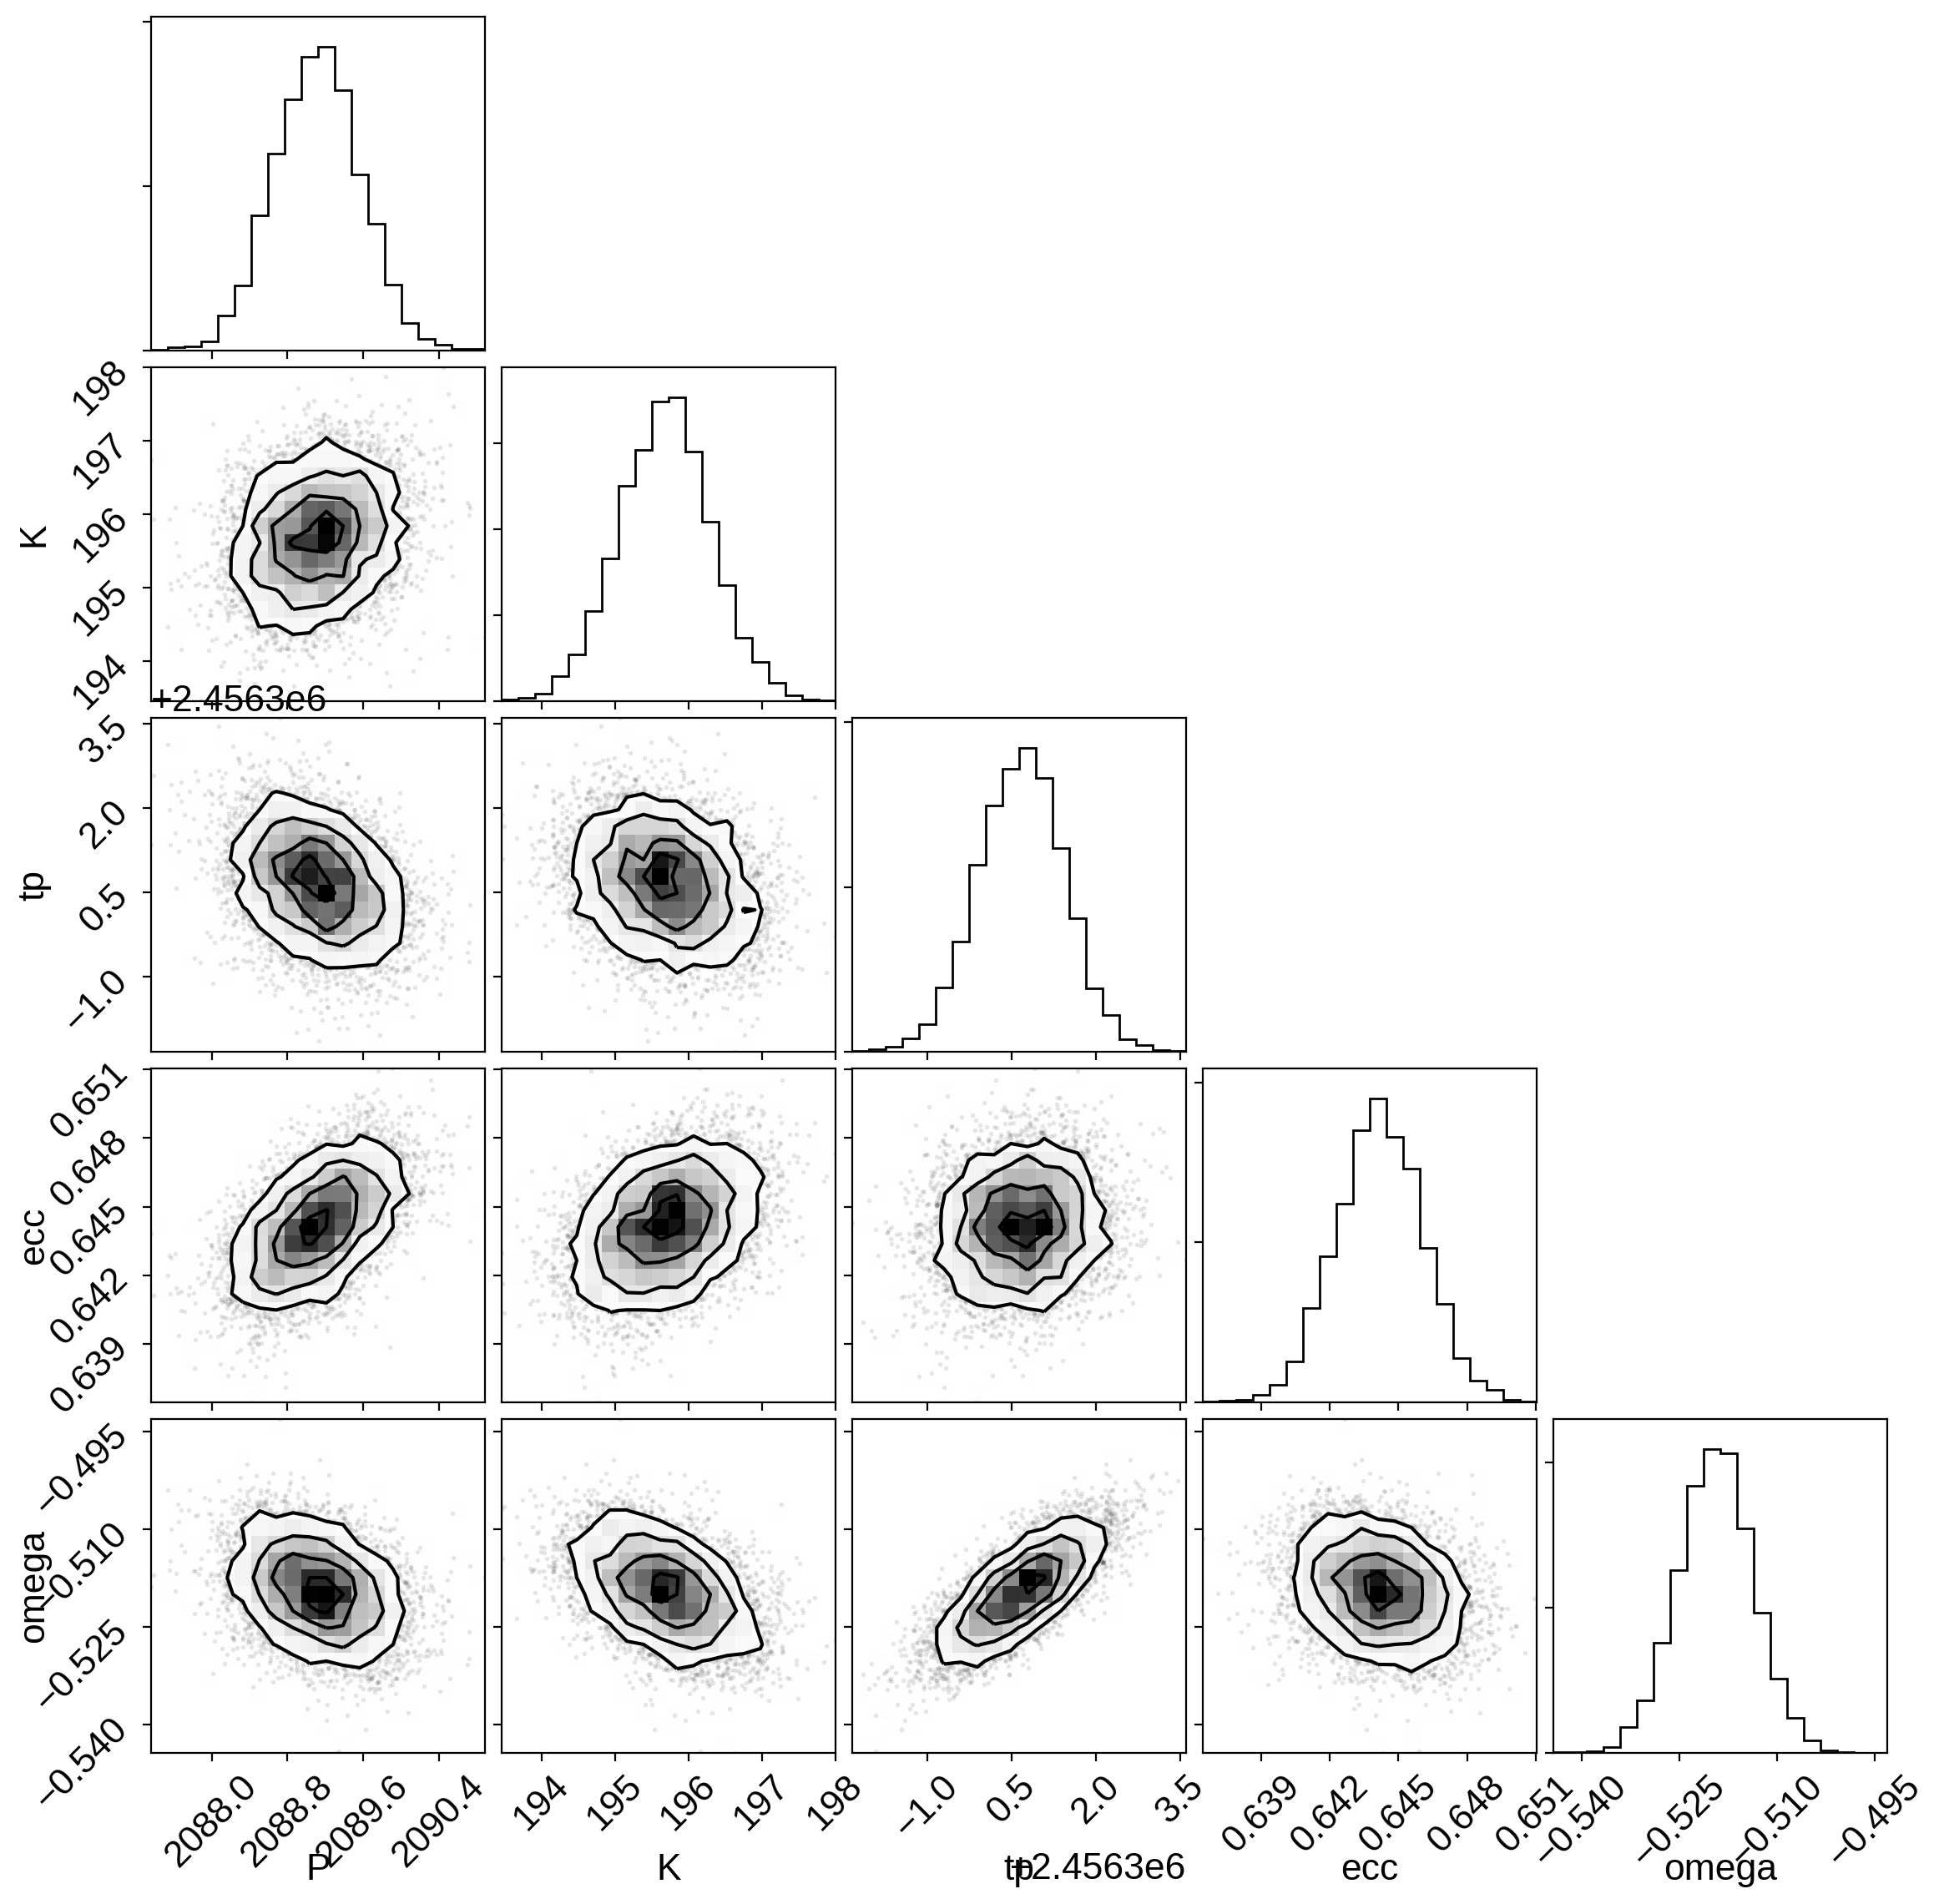

In [7]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["P", "K", "tp", "ecc", "omega"]))

pm.summary(trace, var_names=["P", "K", "tp", "ecc", "omega", "means", "sigmas"])

And finally we can plot the phased RV curve and overplot our posterior inference:

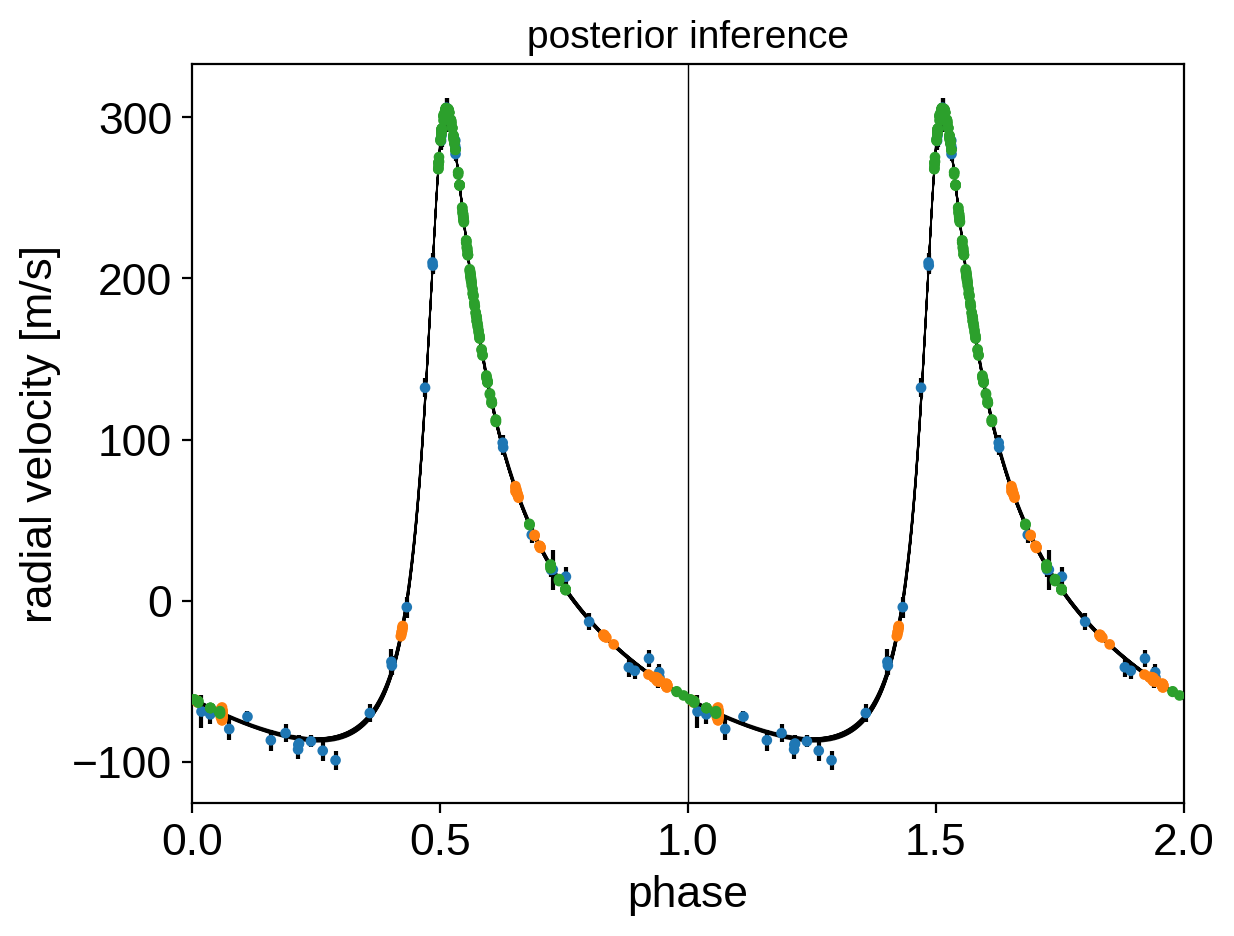

In [8]:
mu = np.mean(trace["mean"] + trace["gp_pred"], axis=0)
mu_var = np.var(trace["mean"], axis=0)
jitter_var = np.median(trace["diag"], axis=0)
period = np.median(trace["P"])
tp = np.median(trace["tp"])

detrended = rv - mu
folded = ((t - tp + 0.5 * period) % period) / period
plt.errorbar(folded, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k")
plt.scatter(
    folded, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10
)
plt.errorbar(folded + 1, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k")
plt.scatter(
    folded + 1, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10
)

t_phase = np.linspace(-0.5, 0.5, 5000)
with model:
    func = xo.get_theano_function_for_var(rv_model(model.P * t_phase + model.tp))
    for point in xo.get_samples_from_trace(trace, 100):
        args = xo.get_args_for_theano_function(point)
        x, y = t_phase + 0.5, func(*args)
        plt.plot(x, y, "k", lw=0.5, alpha=0.5)
        plt.plot(x + 1, y, "k", lw=0.5, alpha=0.5)
plt.axvline(1, color="k", lw=0.5)
plt.xlim(0, 2)
plt.xlabel("phase")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior inference", fontsize=14)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [9]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:pymc3, exoplanet:theano}.


In [10]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
